In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import  Dense, Flatten
from keras.layers import Dense,Flatten,Dropout
from sklearn.metrics import accuracy_score
from keras.applications.inception_v3 import preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.models import Model
from keras import Input
from tensorflow.keras.utils import to_categorical
image_size = 224

In [ ]:
fpath = "/content/drive/MyDrive/Nhom1/DogBreed"
data_path = "/content/drive/MyDrive/Nhom1/data_augmented"
categories = os.listdir(fpath)
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))
num_classes = len(categories)

List of categories =  ['siberian_husky', 'jack_russell', 'golden_retriever', 'chihuahua', 'labrador', 'dachshund', 'corgi', 'pug', 'border_collie', 'bernese_mountain_dog'] 

No. of categories =  10


# Preparing Images

In [ ]:
def resize_image(img):
    img = np.asarray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(img)
    width, height = image.size
    if width == height:
        image = image.resize((image_size,image_size), Image.ANTIALIAS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            image = image.crop((left,top,right,bottom))
            image = image.resize((image_size,image_size), Image.ANTIALIAS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            image = image.crop((left,top,right,bottom))
            image = image.resize((image_size,image_size), Image.ANTIALIAS)
    numpy_image=np.array(image)  
    return numpy_image

In [ ]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        j = 0
        for image_name in os.listdir(data_path+"/"+category):
            img = cv2.imread(data_path+"/"+category+"/"+image_name)  
            img_lst.append(np.array(img))
            labels.append(index)
            j += 1
        print("There are " , j , " images of " , categories[index].upper())     
    return img_lst, labels

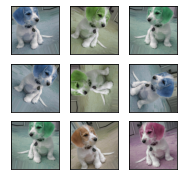

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Nhom1/imagesImage_18.jpg')
img = resize_image(img)
imgs = np.stack( [img for i in range(3*3)], axis=0)

data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    preprocessing_function=lambda x: x[..., np.random.permutation([0, 1, 2])]
)

fig = plt.figure(figsize=(3, 3))
for index, image in enumerate(next(data_gen.flow(imgs)).astype(int)):
    ax = plt.subplot(3, 3, index + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image)
    # cv2.imwrite(str(index)+'.jpg', image)
plt.show()

# Data Augmentation

In [ ]:
def data_augmentation(categories, fpath, data_path):
    for index, category in enumerate(categories):
        j = 0
        os.mkdir(data_path+"/"+category)
        k = 0
        for image_name in os.listdir(fpath+"/"+category):
            
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            image_name_lst = image_name.split('.') 
            resized_img = resize_image(img)
            cv2.imwrite(data_path+"/"+category+"/"+image_name_lst[0]+"_orig"+'.jpg', resized_img)
            k += 1
            imgs = np.stack( [resized_img for i in range(3*3)], axis=0)
            for i, image in enumerate(next(data_gen.flow(imgs)).astype(int)):
                cv2.imwrite(data_path+"/"+category+"/"+image_name_lst[0]+str(i)+'.jpg', image)
                k += 1
            j += 1
        print("There are " , j , " images of " , categories[index].upper())
        print("There are " , k , " images of " , categories[index].upper(), 'after data augmentation') 
        print(' ')   

In [ ]:
data_augmentation(categories, fpath, data_path)

There are  95  images of  SIBERIAN_HUSKY
There are  950  images of  SIBERIAN_HUSKY after data augmentation
 
There are  96  images of  JACK_RUSSELL
There are  960  images of  JACK_RUSSELL after data augmentation
 
There are  83  images of  GOLDEN_RETRIEVER
There are  830  images of  GOLDEN_RETRIEVER after data augmentation
 
There are  92  images of  CHIHUAHUA
There are  920  images of  CHIHUAHUA after data augmentation
 
There are  93  images of  LABRADOR
There are  930  images of  LABRADOR after data augmentation
 
There are  84  images of  DACHSHUND
There are  840  images of  DACHSHUND after data augmentation
 
There are  92  images of  CORGI
There are  920  images of  CORGI after data augmentation
 
There are  94  images of  PUG
There are  940  images of  PUG after data augmentation
 
There are  93  images of  BORDER_COLLIE
There are  930  images of  BORDER_COLLIE after data augmentation
 
There are  96  images of  BERNESE_MOUNTAIN_DOG
There are  960  images of  BERNESE_MOUNTAIN_DO

In [ ]:
new_categories = os.listdir(data_path)
images, labels = load_images_and_labels(new_categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))


There are  950  images of  SIBERIAN_HUSKY
There are  960  images of  JACK_RUSSELL
There are  830  images of  GOLDEN_RETRIEVER
There are  920  images of  CHIHUAHUA
There are  930  images of  LABRADOR
There are  840  images of  DACHSHUND
There are  920  images of  CORGI
There are  940  images of  PUG
There are  930  images of  BORDER_COLLIE
There are  960  images of  BERNESE_MOUNTAIN_DOG
No. of images loaded =  9180 
No. of labels loaded =  9180
<class 'list'> <class 'list'>


In [ ]:
x = np.array(images)
y = np.array(labels)

print("Images shape = ",x.shape,"\nLabels shape = ",y.shape)
print(type(x),type(y))

Images shape =  (9180, 224, 224, 3) 
Labels shape =  (9180,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
#Sample images
import random
ROW = 6
COLUMN = 6
plt.figure(figsize=(20, 20)) 
for i in range(ROW * COLUMN):
    temp = random.randint(0, len(images)+1)
    image = images[temp] 
    plt.subplot(ROW, COLUMN, i+1)       
    plt.imshow(image)  
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(categories[labels[temp]])
    plt.tight_layout()   
    
plt.show()

# Preparing Train, Validation & Test Data


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                   test_size = 0.2,
                                                   stratify=np.array(y), # stratify makes sure that proportion of each class in the output is same as the input
                                                   random_state = 1) 

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                 test_size = 0.2,
                                                 stratify=np.array(y_train),
                                                 random_state = 1)

In [ ]:
print('Training Dataset Size: ', x_train.shape)
print('Validation Dataset Size: ', x_val.shape)
print('Testing Dataset Size: ', x_test.shape)
print('Training Label Size: ', y_train.shape)
print('Validation Label Size: ', y_val.shape)
print('Testing Label Size: ', y_test.shape)

Training Dataset Size:  (5875, 224, 224, 3)
Validation Dataset Size:  (1469, 224, 224, 3)
Testing Dataset Size:  (1836, 224, 224, 3)
Training Label Size:  (5875,)
Validation Label Size:  (1469,)
Testing Label Size:  (1836,)


In [ ]:
def plot_data(y, loc='left'):
    width = 0.37
    if loc == 'left':
        n = -0.7
    elif loc == 'right':
        n = 0.7

    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index] 
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('Dog breed')
    plt.ylabel('Nums of Image')

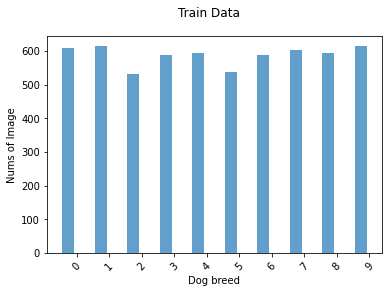

In [ ]:
plt.suptitle('Train Data')
plot_data(y_train, loc='left')

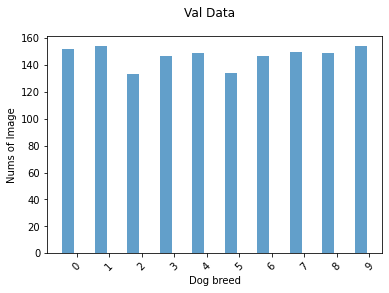

In [ ]:
plt.suptitle('Val Data')
plot_data(y_val, loc='left')

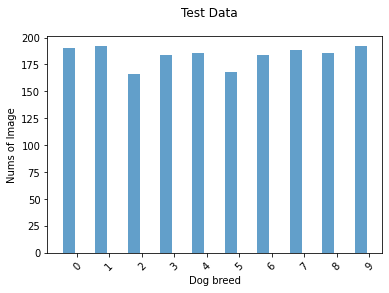

In [ ]:
plt.suptitle('Test Data')
plot_data(y_test, loc='left')

In [ ]:
# Data Augmentation

from keras.preprocessing.image import ImageDataGenerator

batch_size = 128

# Create train generator
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    fill_mode='nearest'
                                  ) # CHECK

train_generator = train_datagen.flow(x_train, y_train,
                                     shuffle = False, batch_size = batch_size, seed = 1)

# Create validation generator
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

val_generator = val_datagen.flow(x_val, y_val,
                                shuffle = False, batch_size = batch_size, seed = 1)

In [ ]:
# Label and one-hot encoding y labels
# Convert labels to one-hot encoded labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y_train = to_categorical(le.transform(y_train), len(categories))
y_train = np.array(y_train)
y_val = to_categorical(le.transform(y_val), len(categories))
y_val = np.array(y_val)


In [ ]:
from keras.callbacks import EarlyStopping
STOPPING_PATIENCE       = 8

In [ ]:
es = EarlyStopping(patience=STOPPING_PATIENCE, 
                   monitor='val_accuracy', 
                   mode='max', 
                   verbose=1, 
                   restore_best_weights=True)


In [ ]:
from keras.applications.vgg16 import VGG16
import tensorflow as tf
from keras import layers, models
from keras.models import Model
from keras import Input

In [ ]:
def get_model():
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)

    # Dong bang cac layer
    for layer in model_vgg16_conv.layers:
        layer.trainable = False

    # Tao model
    input = Input(shape=(224, 224, 3), name='image_input')
    output_vgg16_conv = model_vgg16_conv(input)

    # Them cac layer FC va Dropout
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5)(x)
    x = Dense(10, activation='softmax', name='predictions')(x)

    # Compile
    my_model = Model(inputs=input, outputs=x)
    my_model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), metrics=['accuracy'])

    return my_model


In [ ]:
model = get_model()

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 fc1 (Dense)                 (None, 4096)              102764544 
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 fc2 (Dense)                 (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0     

In [ ]:
# Train Model
train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size
history = model.fit(train_generator,
                             steps_per_epoch = train_steps_per_epoch,
                             validation_data = val_generator,
                             validation_steps = val_steps_per_epoch,
                             epochs = 50, verbose = 1, callbacks=[es])

Epoch 1/50
45/45 [==============================] - 72s 1s/step - loss: 2.1989 - accuracy: 0.2488 - val_loss: 1.3701 - val_accuracy: 0.5469
Epoch 2/50
45/45 [==============================] - 57s 1s/step - loss: 1.5569 - accuracy: 0.4470 - val_loss: 0.9985 - val_accuracy: 0.6989
Epoch 3/50
45/45 [==============================] - 56s 1s/step - loss: 1.2703 - accuracy: 0.5497 - val_loss: 0.8509 - val_accuracy: 0.7116
Epoch 4/50
45/45 [==============================] - 57s 1s/step - loss: 1.1294 - accuracy: 0.6008 - val_loss: 0.6873 - val_accuracy: 0.7741
Epoch 5/50
45/45 [==============================] - 57s 1s/step - loss: 1.0189 - accuracy: 0.6393 - val_loss: 0.6549 - val_accuracy: 0.7827
Epoch 6/50
45/45 [==============================] - 56s 1s/step - loss: 0.9201 - accuracy: 0.6864 - val_loss: 0.5532 - val_accuracy: 0.8210
Epoch 7/50
45/45 [==============================] - 57s 1s/step - loss: 0.8688 - accuracy: 0.6978 - val_loss: 0.5698 - val_accuracy: 0.8047
Epoch 8/50
45/45 [==

# Accuracy and Loss Plots

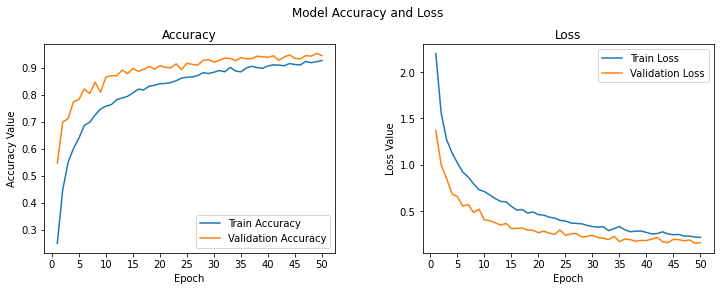

In [ ]:
epochs = 50
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Model Accuracy and Loss', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Predicting on Test Set

In [ ]:
# Evaluate Model on Test Data
x_test1 = x_test / 255. # rescale to 0-1. Divide by 255 as its the max RGB value

In [ ]:
x_test1.shape

(1836, 224, 224, 3)

In [ ]:
y_test.shape

(1836,)

In [ ]:
import seaborn as sns

In [ ]:
def plot_cf_mat(cf_matrix):
    
    classes = categories
    plt.rcParams["figure.figsize"] = (10,7)
    ax = plt.axes()
    sns.heatmap(cf_matrix, annot=True, 
              annot_kws={"size": 10}, 
              xticklabels=classes, 
              yticklabels=classes, ax = ax,fmt="d")
    ax.set_title('Confusion matrix')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.show()

In [ ]:
# Evaluate the model
loss, acc = model.evaluate(x_test1, y_test, verbose=2)
print("Accuracy: {:5.2f}%".format(100 * acc))

58/58 - 6s - loss: 0.1602 - accuracy: 0.9493 - 6s/epoch - 98ms/step
Accuracy: 94.93%


In [ ]:
y_test = to_categorical(le.transform(y_test), len(categories))
y_test = np.array(y_test)

In [ ]:
test_predictions = model.predict(x_test1)
# get model predictions
predictions = np.argmax(test_predictions,axis=1)# get labels and reverse back to get the text labels
# get target labels
target_labels = np.argmax(y_test,axis=1)

In [ ]:
# Plot Actual vs Predicted Images with Confidence Levels
import random
plt.figure(figsize=(30,40))
for counter, i in enumerate(random.sample(range(0, len(y_test)), 30)): # random 30 images
    plt.subplot(6, 5, counter+1)
    plt.subplots_adjust(hspace=0.6)
    actual = str(target_labels[i])
    predicted = str(predictions[i])
    conf = str(max(test_predictions[i]))
    plt.imshow(x_test[i]/255.0)
    plt.axis('off')
    plt.title('Actual: ' + actual + '\nPredict: ' + predicted + '\nConf: ' + conf, fontsize=18)
    
plt.show()

# Model Evaluation

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score

In [ ]:

def model_Evaluate(model):
  
    # Predict values for Test dataset
    y_pred = model.predict(x_test1)
    Y_pred = np.argmax(y_pred, axis=1)
    Y_Test = np.argmax(y_test, axis=1)
    
    class_names = categories
    print("Classification Report:") 
    # Print the evaluation metrics for the dataset.
    print(classification_report(Y_Test, Y_pred, target_names=class_names))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(Y_Test, Y_pred)
    accuracy = recall_score(Y_Test, Y_pred, average=None)
    precision=precision_score(Y_Test,Y_pred,average=None)

    print("Confusion Matrix:")
    print(cf_matrix)
    plot_cf_mat(cf_matrix)
    ## Display the visualization of the Confusion Matrix.
    plt.show()
    
    print("Accuracy for each class: ")
    
    for i in range(len(accuracy)):
        print(f"{class_names[i]}:  {format(accuracy[i]*100, '.2f')}%")
    return accuracy,precision


Classification Report:
                      precision    recall  f1-score   support

      siberian_husky       0.99      0.94      0.96       190
        jack_russell       0.96      0.94      0.95       192
    golden_retriever       0.91      0.93      0.92       166
           chihuahua       0.91      0.98      0.94       184
            labrador       0.95      0.94      0.94       186
           dachshund       0.96      0.96      0.96       168
               corgi       0.97      0.88      0.92       184
                 pug       0.95      0.99      0.97       188
       border_collie       0.95      0.96      0.95       186
bernese_mountain_dog       0.96      0.96      0.96       192

            accuracy                           0.95      1836
           macro avg       0.95      0.95      0.95      1836
        weighted avg       0.95      0.95      0.95      1836

Confusion Matrix:
[[178   0   3   4   1   0   0   0   4   0]
 [  0 181   2   1   5   1   1   0   1   0]
 [

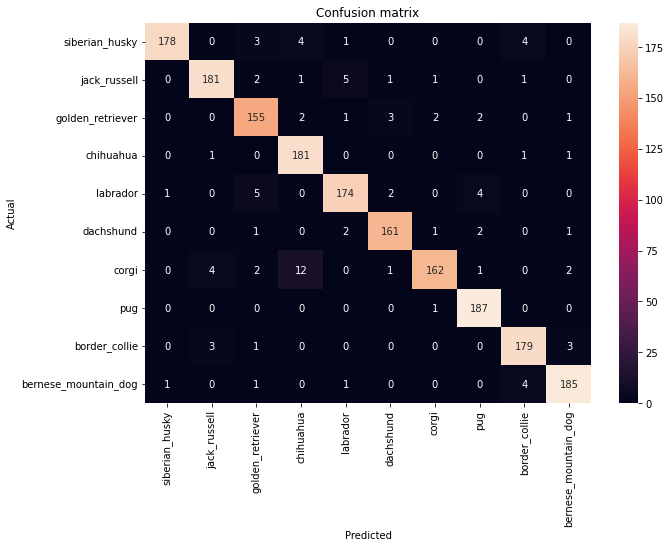

Accuracy for each class: 
siberian_husky:  93.68%
jack_russell:  94.27%
golden_retriever:  93.37%
chihuahua:  98.37%
labrador:  93.55%
dachshund:  95.83%
corgi:  88.04%
pug:  99.47%
border_collie:  96.24%
bernese_mountain_dog:  96.35%


In [ ]:
accuracy, precision = model_Evaluate(model)

# Save model

In [ ]:
model.save("/content/drive/MyDrive/Nhom1/Nhom1_ANN_VGG16.h5")

In [ ]:
restored_model = tf.keras.models.load_model("/content/drive/MyDrive/Nhom1/Nhom1_ANN_VGG16.h5")

In [ ]:
def process_and_predict(file, model):
    im = cv2.imread(file)
    im = resize_image(im)
    plt.imshow(im)
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 224, 224, 3)
    test_predictions = model.predict(ar)
# get model predictions
    maxnum = np.argmax(test_predictions,axis=1)
    if maxnum == 0:
        prediction = 'Siberian Husky'
    elif maxnum == 1:
        prediction = 'Jack Russell Terrier'
    elif maxnum == 2:
        prediction = 'Golden Retriever'
    elif maxnum == 3:
        prediction = 'Chihuahua'
    elif maxnum == 4:
        prediction = 'Labrador'
    elif maxnum == 5:
        prediction = 'Dachshund'
    elif maxnum == 6:
        prediction = 'Corgi'
    elif maxnum == 7:
        prediction = 'Pug'
    elif maxnum == 8:
        prediction = 'Border Collie'
    elif maxnum == 9:
        prediction = 'Bernese Mountain Dog'
    else :
        prediction = 'Not Recognize'
    return prediction

'Siberian Husky'

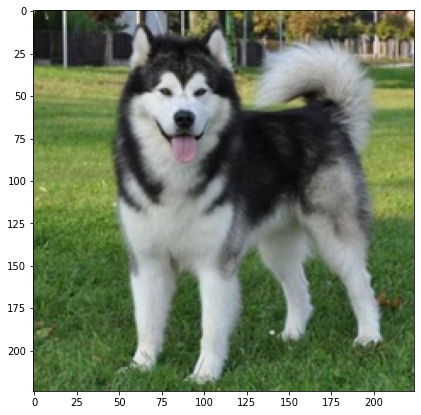

In [ ]:
process_and_predict('/content/drive/MyDrive/Nhom1/test/alaskanmalamute1.jpg',model)

'Corgi'

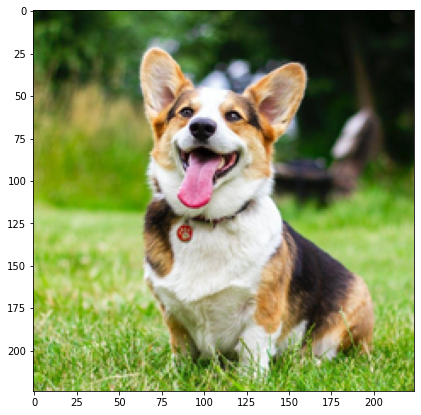

In [ ]:
process_and_predict('/content/drive/MyDrive/Nhom1/test/img_pre_5.jpg',model)

'Siberian Husky'

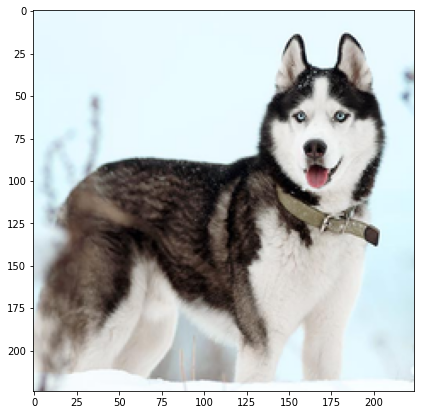

In [ ]:
process_and_predict('/content/drive/MyDrive/Nhom1/test/im_pre_8.jpg',model)

'Chihuahua'

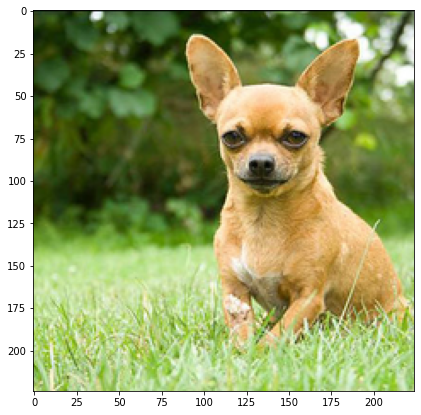

In [ ]:
process_and_predict('/content/drive/MyDrive/Nhom1/test/7.jpg',model)